In [50]:
# group plays by game
# process each game for five factors diff
# get df of ff diff and point diff
# run lin reg
# check against other more recent games

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
    
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2019):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [51]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 2511
Total Drives: 64612
Total Plays: 455669


In [52]:
# Data cleaning
base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

Clean Drives: 44508


In [53]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [56]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ypp = verify_division(sum(team_drives.yards), sum(team_drives.plays))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'YPP': [ypp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffER) + (.25 * ((team_stat_pack.OffSR + (team_stat_pack.YPP / 10))/2)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id):
    game_data = games[games.id == game_id]
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_drives = drives[drives.game_id == game_id]
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]

    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183)

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.375000,0.071429,28.1,4.192982,3.1,0.75,0.4,0.515152,1.15,0.22,0.448845,0.022101
1,Virginia Tech,34,3,0.124335,0.396825,0.079365,26.3,5.492308,3.4,0.60,0.5,0.476190,0.93,-0.22,0.426744,-0.022101


In [ ]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i in range(len(game_ids)):
    gameId = game_ids[i]
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    box_score = calculate_box_score(gameId)
    game_tms = box_score.Team.tolist()
    if ((game_tms[0] in team_list) & (game_tms[1] in team_list)):
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
        stored_game_boxes = stored_game_boxes.append(box_score)
        print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping processing for game_id {gameId} bc one of the teams isn't FBS")

[1/2511] Getting game information for ESPN game_id: 400869090
[1/2511] Started processing game information for ESPN game_id: 400869090
[1/2511] Completed processing game information for ESPN game_id: 400869090
[2/2511] Getting game information for ESPN game_id: 400869421
[2/2511] Started processing game information for ESPN game_id: 400869421
[2/2511] Completed processing game information for ESPN game_id: 400869421
[3/2511] Getting game information for ESPN game_id: 400869257
[3/2511] Skipping processing for game_id 400869257 bc one of the teams isn't FBS
[4/2511] Getting game information for ESPN game_id: 400869502
[4/2511] Skipping processing for game_id 400869502 bc one of the teams isn't FBS
[5/2511] Getting game information for ESPN game_id: 400869503
[5/2511] Skipping processing for game_id 400869503 bc one of the teams isn't FBS
[6/2511] Getting game information for ESPN game_id: 400869341
[6/2511] Started processing game information for ESPN game_id: 400869341
[6/2511] Complet

[48/2511] Skipping processing for game_id 400869652 bc one of the teams isn't FBS
[49/2511] Getting game information for ESPN game_id: 400869619
[49/2511] Skipping processing for game_id 400869619 bc one of the teams isn't FBS
[50/2511] Getting game information for ESPN game_id: 400869427
[50/2511] Skipping processing for game_id 400869427 bc one of the teams isn't FBS
[51/2511] Getting game information for ESPN game_id: 400869261
[51/2511] Started processing game information for ESPN game_id: 400869261
[51/2511] Completed processing game information for ESPN game_id: 400869261
[52/2511] Getting game information for ESPN game_id: 400868970
[52/2511] Started processing game information for ESPN game_id: 400868970
[52/2511] Completed processing game information for ESPN game_id: 400868970
[53/2511] Getting game information for ESPN game_id: 400869096
[53/2511] Skipping processing for game_id 400869096 bc one of the teams isn't FBS
[54/2511] Getting game information for ESPN game_id: 4008

[96/2511] Started processing game information for ESPN game_id: 400868911
[96/2511] Completed processing game information for ESPN game_id: 400868911
[97/2511] Getting game information for ESPN game_id: 400868990
[97/2511] Skipping processing for game_id 400868990 bc one of the teams isn't FBS
[98/2511] Getting game information for ESPN game_id: 400869270
[98/2511] Started processing game information for ESPN game_id: 400869270
[98/2511] Completed processing game information for ESPN game_id: 400869270
[99/2511] Getting game information for ESPN game_id: 400869654
[99/2511] Skipping processing for game_id 400869654 bc one of the teams isn't FBS
[100/2511] Getting game information for ESPN game_id: 400869435
[100/2511] Started processing game information for ESPN game_id: 400869435
[100/2511] Completed processing game information for ESPN game_id: 400869435
[101/2511] Getting game information for ESPN game_id: 400869436
[101/2511] Started processing game information for ESPN game_id: 40

[144/2511] Started processing game information for ESPN game_id: 400868981
[144/2511] Completed processing game information for ESPN game_id: 400868981
[145/2511] Getting game information for ESPN game_id: 400869357
[145/2511] Started processing game information for ESPN game_id: 400869357
[145/2511] Completed processing game information for ESPN game_id: 400869357
[146/2511] Getting game information for ESPN game_id: 400868888
[146/2511] Started processing game information for ESPN game_id: 400868888
[146/2511] Completed processing game information for ESPN game_id: 400868888
[147/2511] Getting game information for ESPN game_id: 400868985
[147/2511] Skipping processing for game_id 400868985 bc one of the teams isn't FBS
[148/2511] Getting game information for ESPN game_id: 400868982
[148/2511] Started processing game information for ESPN game_id: 400868982
[148/2511] Completed processing game information for ESPN game_id: 400868982
[149/2511] Getting game information for ESPN game_id:

[188/2511] Started processing game information for ESPN game_id: 400869111
[188/2511] Completed processing game information for ESPN game_id: 400869111
[189/2511] Getting game information for ESPN game_id: 400869437
[189/2511] Started processing game information for ESPN game_id: 400869437
[189/2511] Completed processing game information for ESPN game_id: 400869437
[190/2511] Getting game information for ESPN game_id: 400869197
[190/2511] Started processing game information for ESPN game_id: 400869197
[190/2511] Completed processing game information for ESPN game_id: 400869197
[191/2511] Getting game information for ESPN game_id: 400868959
[191/2511] Started processing game information for ESPN game_id: 400868959
[191/2511] Completed processing game information for ESPN game_id: 400868959
[192/2511] Getting game information for ESPN game_id: 400869282
[192/2511] Skipping processing for game_id 400869282 bc one of the teams isn't FBS
[193/2511] Getting game information for ESPN game_id:

[232/2511] Started processing game information for ESPN game_id: 400869524
[232/2511] Completed processing game information for ESPN game_id: 400869524
[233/2511] Getting game information for ESPN game_id: 400869118
[233/2511] Started processing game information for ESPN game_id: 400869118
[233/2511] Completed processing game information for ESPN game_id: 400869118
[234/2511] Getting game information for ESPN game_id: 400869659
[234/2511] Started processing game information for ESPN game_id: 400869659
[234/2511] Completed processing game information for ESPN game_id: 400869659
[235/2511] Getting game information for ESPN game_id: 400869005
[235/2511] Started processing game information for ESPN game_id: 400869005
[235/2511] Completed processing game information for ESPN game_id: 400869005
[236/2511] Getting game information for ESPN game_id: 400869448
[236/2511] Started processing game information for ESPN game_id: 400869448
[236/2511] Completed processing game information for ESPN gam

[272/2511] Started processing game information for ESPN game_id: 400869365
[272/2511] Completed processing game information for ESPN game_id: 400869365
[273/2511] Getting game information for ESPN game_id: 400868913
[273/2511] Started processing game information for ESPN game_id: 400868913
[273/2511] Completed processing game information for ESPN game_id: 400868913
[274/2511] Getting game information for ESPN game_id: 400869815
[274/2511] Skipping processing for game_id 400869815 bc one of the teams isn't FBS
[275/2511] Getting game information for ESPN game_id: 400869605
[275/2511] Skipping processing for game_id 400869605 bc one of the teams isn't FBS
[276/2511] Getting game information for ESPN game_id: 400869004
[276/2511] Started processing game information for ESPN game_id: 400869004
[276/2511] Completed processing game information for ESPN game_id: 400869004
[277/2511] Getting game information for ESPN game_id: 400869660
[277/2511] Started processing game information for ESPN ga

[312/2511] Started processing game information for ESPN game_id: 400869455
[312/2511] Completed processing game information for ESPN game_id: 400869455
[313/2511] Getting game information for ESPN game_id: 400869665
[313/2511] Started processing game information for ESPN game_id: 400869665
[313/2511] Completed processing game information for ESPN game_id: 400869665
[314/2511] Getting game information for ESPN game_id: 400869206
[314/2511] Started processing game information for ESPN game_id: 400869206
[314/2511] Completed processing game information for ESPN game_id: 400869206
[315/2511] Getting game information for ESPN game_id: 400869012
[315/2511] Started processing game information for ESPN game_id: 400869012
[315/2511] Completed processing game information for ESPN game_id: 400869012
[316/2511] Getting game information for ESPN game_id: 400869297
[316/2511] Started processing game information for ESPN game_id: 400869297
[316/2511] Completed processing game information for ESPN gam

[352/2511] Started processing game information for ESPN game_id: 400869531
[352/2511] Completed processing game information for ESPN game_id: 400869531
[353/2511] Getting game information for ESPN game_id: 400869379
[353/2511] Started processing game information for ESPN game_id: 400869379
[353/2511] Completed processing game information for ESPN game_id: 400869379
[354/2511] Getting game information for ESPN game_id: 400869457
[354/2511] Started processing game information for ESPN game_id: 400869457
[354/2511] Completed processing game information for ESPN game_id: 400869457
[355/2511] Getting game information for ESPN game_id: 400869533
[355/2511] Started processing game information for ESPN game_id: 400869533
[355/2511] Completed processing game information for ESPN game_id: 400869533
[356/2511] Getting game information for ESPN game_id: 400868962
[356/2511] Started processing game information for ESPN game_id: 400868962
[356/2511] Completed processing game information for ESPN gam

[392/2511] Skipping processing for game_id 400869824 bc one of the teams isn't FBS
[393/2511] Getting game information for ESPN game_id: 400869216
[393/2511] Started processing game information for ESPN game_id: 400869216
[393/2511] Completed processing game information for ESPN game_id: 400869216
[394/2511] Getting game information for ESPN game_id: 400869133
[394/2511] Started processing game information for ESPN game_id: 400869133
[394/2511] Completed processing game information for ESPN game_id: 400869133
[395/2511] Getting game information for ESPN game_id: 400869378
[395/2511] Started processing game information for ESPN game_id: 400869378
[395/2511] Completed processing game information for ESPN game_id: 400869378
[396/2511] Getting game information for ESPN game_id: 400869722
[396/2511] Started processing game information for ESPN game_id: 400869722
[396/2511] Completed processing game information for ESPN game_id: 400869722
[397/2511] Getting game information for ESPN game_id:

[432/2511] Started processing game information for ESPN game_id: 400869306
[432/2511] Completed processing game information for ESPN game_id: 400869306
[433/2511] Getting game information for ESPN game_id: 400869723
[433/2511] Started processing game information for ESPN game_id: 400869723
[433/2511] Completed processing game information for ESPN game_id: 400869723
[434/2511] Getting game information for ESPN game_id: 400869670
[434/2511] Started processing game information for ESPN game_id: 400869670
[434/2511] Completed processing game information for ESPN game_id: 400869670
[435/2511] Getting game information for ESPN game_id: 400868880
[435/2511] Started processing game information for ESPN game_id: 400868880
[435/2511] Completed processing game information for ESPN game_id: 400868880
[436/2511] Getting game information for ESPN game_id: 400869310
[436/2511] Started processing game information for ESPN game_id: 400869310
[436/2511] Completed processing game information for ESPN gam

[471/2511] Started processing game information for ESPN game_id: 400869609
[471/2511] Completed processing game information for ESPN game_id: 400869609
[472/2511] Getting game information for ESPN game_id: 400869638
[472/2511] Started processing game information for ESPN game_id: 400869638
[472/2511] Completed processing game information for ESPN game_id: 400869638
[473/2511] Getting game information for ESPN game_id: 400868964
[473/2511] Started processing game information for ESPN game_id: 400868964
[473/2511] Completed processing game information for ESPN game_id: 400868964
[474/2511] Getting game information for ESPN game_id: 400868916
[474/2511] Started processing game information for ESPN game_id: 400868916
[474/2511] Completed processing game information for ESPN game_id: 400868916
[475/2511] Getting game information for ESPN game_id: 400869543
[475/2511] Started processing game information for ESPN game_id: 400869543
[475/2511] Completed processing game information for ESPN gam

[511/2511] Started processing game information for ESPN game_id: 400869227
[511/2511] Completed processing game information for ESPN game_id: 400869227
[512/2511] Getting game information for ESPN game_id: 400869032
[512/2511] Started processing game information for ESPN game_id: 400869032
[512/2511] Completed processing game information for ESPN game_id: 400869032
[513/2511] Getting game information for ESPN game_id: 400869141
[513/2511] Started processing game information for ESPN game_id: 400869141
[513/2511] Completed processing game information for ESPN game_id: 400869141
[514/2511] Getting game information for ESPN game_id: 400869229
[514/2511] Started processing game information for ESPN game_id: 400869229
[514/2511] Completed processing game information for ESPN game_id: 400869229
[515/2511] Getting game information for ESPN game_id: 400869228
[515/2511] Started processing game information for ESPN game_id: 400869228
[515/2511] Completed processing game information for ESPN gam

[551/2511] Started processing game information for ESPN game_id: 400869837
[551/2511] Completed processing game information for ESPN game_id: 400869837
[552/2511] Getting game information for ESPN game_id: 400869836
[552/2511] Started processing game information for ESPN game_id: 400869836
[552/2511] Completed processing game information for ESPN game_id: 400869836
[553/2511] Getting game information for ESPN game_id: 400869683
[553/2511] Started processing game information for ESPN game_id: 400869683
[553/2511] Completed processing game information for ESPN game_id: 400869683
[554/2511] Getting game information for ESPN game_id: 400869601
[554/2511] Started processing game information for ESPN game_id: 400869601
[554/2511] Completed processing game information for ESPN game_id: 400869601
[555/2511] Getting game information for ESPN game_id: 400869232
[555/2511] Started processing game information for ESPN game_id: 400869232
[555/2511] Completed processing game information for ESPN gam

[591/2511] Started processing game information for ESPN game_id: 400869480
[591/2511] Completed processing game information for ESPN game_id: 400869480
[592/2511] Getting game information for ESPN game_id: 400869403
[592/2511] Started processing game information for ESPN game_id: 400869403
[592/2511] Completed processing game information for ESPN game_id: 400869403
[593/2511] Getting game information for ESPN game_id: 400869482
[593/2511] Started processing game information for ESPN game_id: 400869482
[593/2511] Completed processing game information for ESPN game_id: 400869482
[594/2511] Getting game information for ESPN game_id: 400869041
[594/2511] Started processing game information for ESPN game_id: 400869041
[594/2511] Completed processing game information for ESPN game_id: 400869041
[595/2511] Getting game information for ESPN game_id: 400869686
[595/2511] Started processing game information for ESPN game_id: 400869686
[595/2511] Completed processing game information for ESPN gam

[630/2511] Started processing game information for ESPN game_id: 400869154
[630/2511] Completed processing game information for ESPN game_id: 400869154
[631/2511] Getting game information for ESPN game_id: 400869325
[631/2511] Started processing game information for ESPN game_id: 400869325
[631/2511] Completed processing game information for ESPN game_id: 400869325
[632/2511] Getting game information for ESPN game_id: 400869326
[632/2511] Started processing game information for ESPN game_id: 400869326
[632/2511] Completed processing game information for ESPN game_id: 400869326
[633/2511] Getting game information for ESPN game_id: 400869328
[633/2511] Started processing game information for ESPN game_id: 400869328
[633/2511] Completed processing game information for ESPN game_id: 400869328
[634/2511] Getting game information for ESPN game_id: 400869327
[634/2511] Started processing game information for ESPN game_id: 400869327
[634/2511] Completed processing game information for ESPN gam

In [15]:
stored_game_boxes

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Hawai'i,43,9,0.668260,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Colorado State,34,-9,0.331740,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
0,Wyoming,29,22,0.995728,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,New Mexico State,7,-22,0.004272,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
0,UCF,56,39,0.995797,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Connecticut,17,-39,0.004203,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
0,New Mexico State,10,-38,0.000036,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Minnesota,48,38,0.999964,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
0,Wake Forest,23,6,0.780339,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Tulane,17,-6,0.219661,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


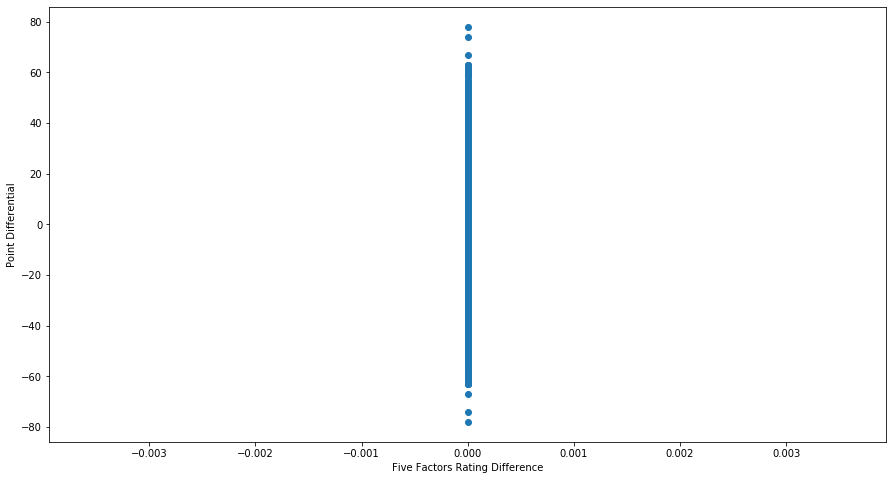

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [17]:
# Eliminate outliers
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [18]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score


In [19]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

In [ ]:
sample_box = calculate_box_score(401013183) # 2018 UVA at VT for sample
mu = basis['5FRDiff'].mean()
std = basis['5FRDiff'].std()

max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
print("")
proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {proj_point_diff}")
z = (proj_point_diff - mu) / std
print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {100 * stats.norm.cdf(z)}%")

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Virginia Tech,34,3,0.124335,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
